In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.distributions as D

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_theme(style="dark")

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Flow(nn.Module):
    def __init__(self, latent_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2 + 1, latent_dim),
            nn.ELU(),
            nn.Linear(latent_dim, latent_dim),
            nn.ELU(),
            nn.Linear(latent_dim, latent_dim),
            nn.ELU(),
            nn.Linear(latent_dim, latent_dim),
            nn.ELU(),
            nn.Linear(latent_dim, 2),
        )

    def forward(self, x, t):
        emb_t = torch.as_tensor(t).expand(x.shape[0], -1)
        emb_x = torch.cat([x, emb_t], dim=1)
        return self.net(emb_x)

    def ode_forward(self, t, x):
        t = t.expand(x.shape[0]).reshape(-1, 1)
        return self.forward(x, t)

In [4]:
from typing import Callable


class BlobsDataset(Dataset):
    def __init__(
        self,
        initial_dist: Callable[[tuple[int, ...]], torch.Tensor],
        target_dist: Callable[[tuple[int, ...]], torch.Tensor],
        num_samples: int = 1024,
        device: torch.device | None = None,
        t_dist: Callable[[], torch.Tensor] | None = None,
    ):
        self.device = device
        self.p = initial_dist
        self.X = target_dist((num_samples,))
        self.sample_t = t_dist or (lambda: torch.rand(1))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        p0 = self.p((1,))[0]
        p1 = self.X[idx]
        if self.device:
            return p0.to(self.device), p1.to(self.device)
        return p0, p1

In [5]:
def time_distribution():
    return torch.rand(1)

In [6]:
def create_gmm_sampler(
    means: list[tuple[float, float]], stds: list[float]
) -> Callable[[tuple[int, ...]], torch.Tensor]:
    means_t = torch.tensor(means)
    stds_t = torch.tensor(stds).unsqueeze(1).expand_as(means_t)
    num_components = len(means)

    mix = D.Categorical(torch.ones(num_components))
    components = D.Independent(D.Normal(loc=means_t, scale=stds_t), 1)
    gmm = D.MixtureSameFamily(mix, components)

    return gmm.sample


p0_mu = [(-3.0, 2.0), (-3.0, -2.0)]
p0_std = [0.4, 0.4]

p1_mu = [(3.0, -2.0), (3.0, 2.0)]
p1_std = [0.4, 0.4]

sample_p0 = create_gmm_sampler(means=p0_mu, stds=p0_std)
sample_p1 = create_gmm_sampler(means=p1_mu, stds=p1_std)

In [7]:
data = BlobsDataset(
    num_samples=1024,
    initial_dist=sample_p0,
    target_dist=sample_p1,
    device=DEVICE,
    t_dist=time_distribution,
)
dataloader = DataLoader(data, batch_size=128, shuffle=True)

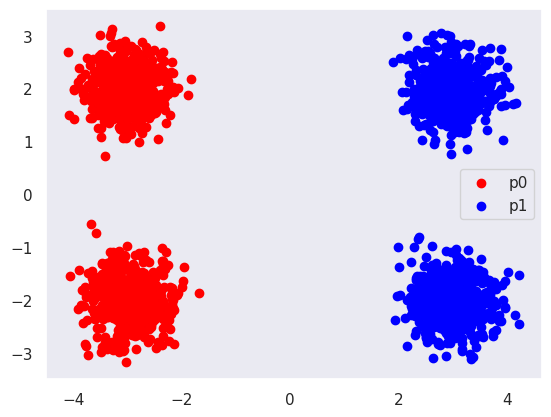

In [8]:
p0s = []
p1s = []
for batch in dataloader:
    p0s.append(batch[0])
    p1s.append(batch[1])
p0s = torch.cat(p0s, dim=0).cpu().numpy()
p1s = torch.cat(p1s, dim=0).cpu().numpy()

plt.scatter(p0s[:, 0], p0s[:, 1], c="red", label="p0")
plt.scatter(p1s[:, 0], p1s[:, 1], c="blue", label="p1")
plt.legend()
plt.show()

In [9]:
N_EPOCHS = 200

model = Flow().to(DEVICE)
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCHS)

In [10]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    n_epochs: int,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.CosineAnnealingLR,
    t_dist: Callable[[], torch.Tensor] | None = None,
    verbose: bool = False,
):
    log_interval = n_epochs // 10
    t_dist = t_dist or (lambda: torch.rand(p0.shape[0], 1))
    model.train()
    loss_history = []
    for epoch in range(n_epochs):
        losses = []
        for p0, p1 in dataloader:
            p0, p1 = p0.to(DEVICE), p1.to(DEVICE)
            t = t_dist().to(DEVICE)
            z = t * p1 + (1 - t) * p0
            target_flow = p1 - p0
            flow = model(z, t)
            loss = F.mse_loss(flow, target_flow)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        scheduler.step()
        if epoch % log_interval == 0 or epoch == n_epochs - 1:
            if verbose:
                print(f"Epoch {epoch} loss: {np.mean(losses):.4f}")
        loss_history.append(np.mean(losses))
    return loss_history

Epoch 0 loss: 19.5104
Epoch 20 loss: 3.2909
Epoch 40 loss: 3.1797
Epoch 60 loss: 3.3385
Epoch 80 loss: 2.8476
Epoch 100 loss: 2.2598
Epoch 120 loss: 2.5306
Epoch 140 loss: 2.3695
Epoch 160 loss: 2.2733
Epoch 180 loss: 2.3064
Epoch 199 loss: 2.2946


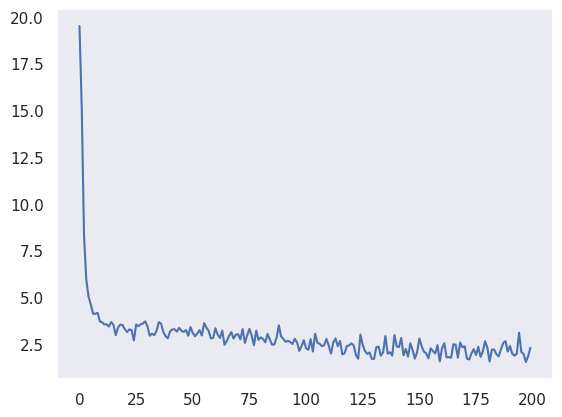

In [11]:
loss_history = train(
    model=model,
    dataloader=dataloader,
    n_epochs=N_EPOCHS,
    optimizer=optimizer,
    scheduler=scheduler,
    t_dist=time_distribution,
    verbose=True,
)
plt.plot(loss_history)
plt.show()


In [12]:
from sklearn.mixture import GaussianMixture
from torchdiffeq import odeint
from matplotlib.collections import LineCollection
from typing import cast


@torch.no_grad()
def sample_with_ode(
    model: nn.Module,
    initial_dist: Callable[[tuple[int, ...]], torch.Tensor],
    n_samples: int = 500,
    n_steps: int = 100,
):
    model.eval()
    initial_samples = torch.randn(n_samples, 2).to(DEVICE)
    initial_samples = initial_dist((n_samples,)).to(DEVICE)
    t_span = torch.linspace(0.0, 1.0, n_steps).to(DEVICE)
    trajectory = odeint(
        model.ode_forward,
        initial_samples,
        t_span,
        method="dopri5",
        atol=1e-5,
        rtol=1e-5,
    )
    trajectory = cast(torch.Tensor, trajectory)

    return trajectory.cpu().numpy()


def general_plot(model, title: str = "", n_samples: int = 500, n_steps: int = 20):
    samples = sample_with_ode(
        model, initial_dist=sample_p0, n_samples=n_samples, n_steps=n_steps
    )

    final_samples = samples[-1]
    initial_samples = samples[0]

    segments_below = []
    segments_above = []
    trajectory_per_sample = np.transpose(samples, (1, 0, 2))
    for sample_path in trajectory_per_sample:
        # sample path is 20x2
        # segments.extend(zip(sample_path[:-1], sample_path[1:]))
        if sample_path[0][1] < 0:
            segments_below.extend(zip(sample_path[:-1], sample_path[1:]))
        else:
            segments_above.extend(zip(sample_path[:-1], sample_path[1:]))


    # lines = LineCollection(segments, colors="gray", linewidths=0.25, alpha=0.3)
    lines_below = LineCollection(segments_below, colors="purple", linewidths=0.25, alpha=0.3)
    lines_above = LineCollection(segments_above, colors="green", linewidths=0.25, alpha=0.3)

    target_data_np = data.X.cpu().numpy()

    gmm = GaussianMixture(n_components=len(p1_mu), random_state=42)
    gmm.fit(target_data_np)

    x_min, x_max = target_data_np[:, 0].min() - 1, target_data_np[:, 0].max() + 1
    y_min, y_max = target_data_np[:, 1].min() - 1, target_data_np[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    log_probs = gmm.score_samples(grid_points)
    Z = np.exp(log_probs).reshape(xx.shape)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.contourf(xx, yy, Z, levels=20, cmap="Blues", alpha=1.0)
    ax.contour(xx, yy, Z, levels=10, colors="black", linewidths=0.5, alpha=0.4)
    ax.scatter(
        initial_samples[:, 0],
        initial_samples[:, 1],
        c="red",
        label="initial",
        alpha=0.25,
    )
    ax.scatter(
        final_samples[:, 0],
        final_samples[:, 1],
        c="blue",
        label="final",
        alpha=0.25,
        edgecolors="black",
        linewidth=0.5,
    )

    ax.add_collection(lines_below)
    ax.add_collection(lines_above)
    ax.legend()
    ax.set_aspect("equal")
    ax.set_title(f"{title} | {n_steps} steps")
    plt.show()

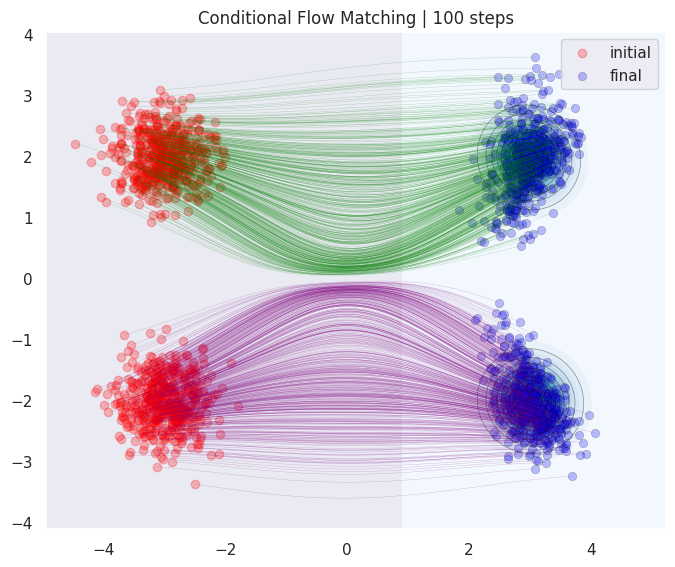

In [13]:
general_plot(model, title="Conditional Flow Matching", n_samples=1000, n_steps=100)

In [14]:
from torch.utils.data import TensorDataset


@torch.no_grad()
def generate_rectified_dataset(
    model_v0: nn.Module, original_dataset: torch.Tensor, n_steps=100, batch_size=512
):
    model_v0.eval()
    t_span = torch.linspace(1.0, 0.0, n_steps).to(DEVICE)
    p1_data = original_dataset.to(DEVICE)

    p0_rectified_list = []
    for p1_batch in torch.split(p1_data, batch_size):
        p0_batch = odeint(
            model_v0.ode_forward,
            p1_batch,
            t_span,
            method="dopri5",
            atol=1e-5,
            rtol=1e-5,
        )[-1]
        p0_rectified_list.append(p0_batch)

    p0_rectified = torch.cat(p0_rectified_list, dim=0)
    return TensorDataset(p0_rectified.cpu(), original_dataset.cpu())


In [15]:
N_EPOCHS_RF = 100
rf_model = Flow().to(DEVICE)
rectified_dataset = generate_rectified_dataset(model_v0=model, original_dataset=data.X)
dataloader = DataLoader(rectified_dataset, batch_size=128, shuffle=True)
optimizer = AdamW(rf_model.parameters(), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCHS_RF)

In [16]:
loss_history = train(
    rf_model,
    dataloader,
    n_epochs=N_EPOCHS_RF,
    optimizer=optimizer,
    scheduler=scheduler,
    t_dist=time_distribution,
)

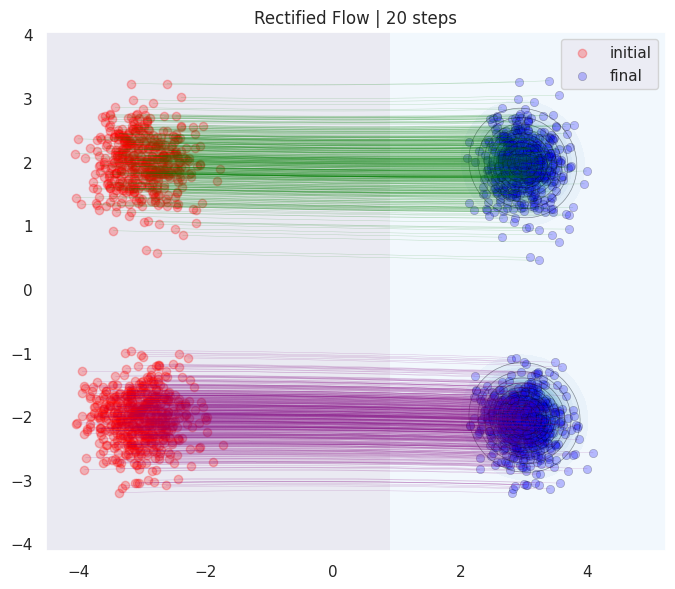

In [17]:
general_plot(rf_model, title="Rectified Flow", n_samples=1000, n_steps=20)

In [18]:
rf_model_2 = Flow().to(DEVICE)
rectified_dataset = generate_rectified_dataset(
    model_v0=rf_model, original_dataset=data.X
)
dataloader = DataLoader(rectified_dataset, batch_size=128, shuffle=True)
optimizer = AdamW(rf_model_2.parameters(), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCHS_RF)

In [19]:
loss_history = train(
    rf_model_2,
    dataloader,
    n_epochs=N_EPOCHS_RF,
    optimizer=optimizer,
    scheduler=scheduler,
    t_dist=time_distribution,
)

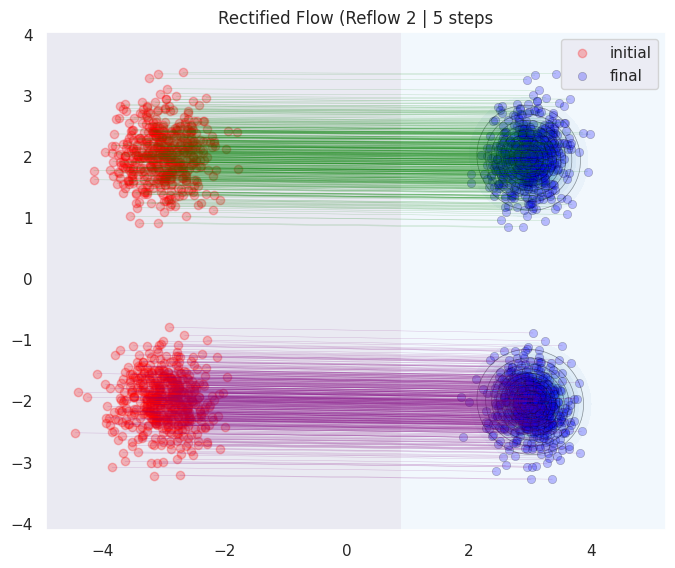

In [20]:
general_plot(rf_model_2, title="Rectified Flow (Reflow 2", n_samples=1000, n_steps=5)